In [136]:
# # Connect to the Google Account

# import subprocess
# # Install the Google Cloud SDK
# subprocess.run(["gcloud", "auth", "application-default", "login"])

In [137]:
from google.cloud import bigquery
import pandas as pd
import os

# Initialize BigQuery client
client = bigquery.Client()

# Function to run queries and return DataFrame
def run_query(query):
    return client.query(query).to_dataframe()

In [138]:
# 1. Get basic patient info (admissions + demographics)
patient_info_query = """
SELECT adm.subject_id, adm.hadm_id, adm.admittime, adm.dischtime, pat.gender, pat.anchor_age AS age
FROM `physionet-data.mimiciv_hosp.admissions` AS adm
JOIN `physionet-data.mimiciv_hosp.patients` AS pat
ON adm.subject_id = pat.subject_id
WHERE adm.admittime IS NOT NULL
"""
patient_info_df = run_query(patient_info_query)

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [151]:
# Count number of patients
num_patients = patient_info_df['subject_id'].nunique()
print(f"Number of patients: {num_patients}")

Number of patients: 180733


In [139]:
# 2. Get item IDs for lipase tests
lipase_item_query = """
SELECT itemid, label
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE LOWER(label) LIKE '%lipase%'
"""
lipase_items_df = run_query(lipase_item_query)
print(lipase_items_df)
lipase_itemids = [50956, 50844, 51055, 51036]  # Lipase item IDs

   itemid               label
0   50956              Lipase
1   50844     Lipase, Ascites
2   51055     Lipase, Pleural
3   51036  Lipase, Body Fluid


In [140]:
# 3. Retrieve lipase values
lipase_values_query = f"""
SELECT subject_id, hadm_id, charttime, valuenum AS lipase_level
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid IN ({', '.join(map(str, lipase_itemids))})
ORDER BY subject_id, charttime
"""
lipase_values_df = run_query(lipase_values_query)

# Merge lipase values with patient info and clean data
merged_df = pd.merge(lipase_values_df, patient_info_df, on=['subject_id', 'hadm_id'], how='left')
merged_df.dropna(subset=['age', 'lipase_level'], inplace=True)

# Identify patients with high lipase levels
def check_lipase(row):
    return row['lipase_level'] >= (140 if row['age'] < 60 else 151)

high_lipase_df = merged_df[merged_df.apply(check_lipase, axis=1)]

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [148]:
# Count number of patients with high lipase levels
num_patients = high_lipase_df['subject_id'].nunique()
print(f"Number of patients with high lipase levels: {num_patients}")

Number of patients with high lipase levels: 4546


In [141]:
# 4. Get item IDs related to CT scans
ct_item_query = """
SELECT itemid, label
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) LIKE '%computed tomography%'
   OR LOWER(label) LIKE '%abdomen%'
   OR LOWER(label) LIKE '%pelvis%'
   OR LOWER(label) LIKE '%scan%'
"""
ct_items_df = run_query(ct_item_query)
print(ct_items_df)
ct_itemids = [221214, 229582]  # CT item IDs

# Retrieve CT scan events
ct_scan_query = f"""
SELECT subject_id, hadm_id, stay_id, starttime, endtime, itemid, value
FROM `physionet-data.mimiciv_icu.procedureevents`
WHERE itemid IN ({', '.join(map(str, ct_itemids))})
ORDER BY subject_id, starttime
"""
ct_scan_df = run_query(ct_scan_query)

# Merge high lipase patients with CT scan records
merged_ct_df = pd.merge(high_lipase_df, ct_scan_df, on=['subject_id', 'hadm_id'], how='inner')

# Calculate length of stay
patient_info_df['admittime'] = pd.to_datetime(patient_info_df['admittime'])
patient_info_df['dischtime'] = pd.to_datetime(patient_info_df['dischtime'])
patient_info_df['length_of_stay'] = (patient_info_df['dischtime'] - patient_info_df['admittime']).dt.total_seconds() / (60 * 60 * 24)

# Merge length of stay into the dataset
merged_ct_df = pd.merge(merged_ct_df, patient_info_df[['subject_id', 'hadm_id', 'length_of_stay']], on=['subject_id', 'hadm_id'], how='left')

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   itemid                                      label
0  225999               Vanilla Scandi Shake (mixed)
1  226000             Chocolate Scandi Shake (mixed)
2  226002  Vanilla Lactose Free Scandi Shake (mixed)
3  221214                                    CT scan
4  225461                                     Pelvis
5  229582                           Portable CT scan
6  228714                            Bladder scanned
7  229371                      Bladder Scan Estimate
8  220462                                   Scandium


/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [164]:
# Count the number of patients with high lipase levels who had a CT scan
num_patients_ct = merged_ct_df['subject_id'].nunique()
print(f"Number of patients with high lipase levels who had a CT scan: {num_patients_ct}")

# Count the number of rows in the dataset
num_rows = merged_ct_df.shape[0]
print(f"Number of rows in the dataset: {num_rows}")

Number of patients with high lipase levels who had a CT scan: 791
Number of rows in the dataset: 6723


In [142]:
# 5. Retrieve comorbid conditions (ICD codes)
hadm_ids = ', '.join(str(hadm_id) for hadm_id in merged_ct_df['hadm_id'].unique())
comorbidity_query = f"""
SELECT subject_id, hadm_id, icd_code, seq_num, icd_version
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE hadm_id IN ({hadm_ids})
ORDER BY subject_id, hadm_id, seq_num
"""
comorbidities_df = run_query(comorbidity_query)

# Merge comorbidities with the dataset
merged_comorbidities_df = pd.merge(merged_ct_df, comorbidities_df, on=['subject_id', 'hadm_id'], how='left')

# Display the final merged dataset
print(merged_comorbidities_df.head())

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   subject_id   hadm_id           charttime  lipase_level           admittime  \
0    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
1    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
2    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
3    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
4    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   

            dischtime gender  age   stay_id           starttime  \
0 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
1 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
2 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
3 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
4 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   

              endtime  itemid  value  length_of_stay icd_code  seq_num  \
0 2159-09-28 16:37:00  221214    1.0

In [144]:
# 6. Retrieve mortality information from admissions table
mortality_query = """
SELECT subject_id, hadm_id, hospital_expire_flag
FROM `physionet-data.mimiciv_hosp.admissions`
"""
mortality_df = run_query(mortality_query)

# Add a column to indicate if the patient died during the hospital stay
mortality_df['in_hospital_death'] = mortality_df['hospital_expire_flag'] == 1

# Merge mortality information into the existing dataset
merged_comorbidities_df = pd.merge(merged_comorbidities_df, mortality_df[['subject_id', 'hadm_id', 'in_hospital_death']], on=['subject_id', 'hadm_id'], how='left')

# Display the first few rows of the updated dataset
print(merged_comorbidities_df.head())

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   subject_id   hadm_id           charttime  lipase_level           admittime  \
0    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
1    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
2    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
3    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   
4    10017531  22580355 2159-09-22 20:56:00        1164.0 2159-09-22 19:30:00   

            dischtime gender  age   stay_id           starttime  \
0 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
1 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
2 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
3 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   
4 2159-10-24 13:40:00      M   63  35526828 2159-09-28 16:36:00   

              endtime  itemid  value  length_of_stay icd_code  seq_num  \
0 2159-09-28 16:37:00  221214    1.0

In [145]:
# Count the number of unique patients who died in the hospital
num_patients_with_death_info = merged_comorbidities_df[merged_comorbidities_df['in_hospital_death'] == True][['subject_id', 'hadm_id']].drop_duplicates().shape[0]
print(f"Number of unique patients who died in the hospital: {num_patients_with_death_info}")

Number of unique patients who died in the hospital: 196


# EDA

In [153]:
# 1. Handle missing values
missing_data = merged_comorbidities_df.isnull().sum()
print(missing_data)

subject_id           0
hadm_id              0
charttime            0
lipase_level         0
admittime            0
dischtime            0
gender               0
age                  0
stay_id              0
starttime            0
endtime              0
itemid               0
value                0
length_of_stay       0
icd_code             0
seq_num              0
icd_version          0
in_hospital_death    0
dtype: int64


In [152]:
# 2. Statistical summary
summary = merged_comorbidities_df.describe()
print(summary)

            subject_id          hadm_id                   charttime  \
count         183680.0         183680.0                      183680   
mean   15128430.438954  25131823.989465  2158-02-20 00:41:27.081337   
min         10017531.0       20024364.0         2110-02-04 19:35:00   
25%         12624383.0       22548939.0         2138-12-22 02:24:00   
50%         15479539.0       24922530.0         2162-09-06 03:52:00   
75%         17396841.0       27565878.0         2180-08-12 23:01:00   
max         19997367.0       29995505.0         2208-06-28 07:48:00   
std     2867727.851051   2822306.858589                         NaN   

        lipase_level                   admittime                   dischtime  \
count  183680.000000                      183680                      183680   
mean      669.871483  2158-02-02 08:18:56.878157  2158-03-21 15:34:24.761107   
min       140.000000         2110-02-04 18:22:00         2110-02-07 00:05:00   
25%       192.000000         2138-12-09 

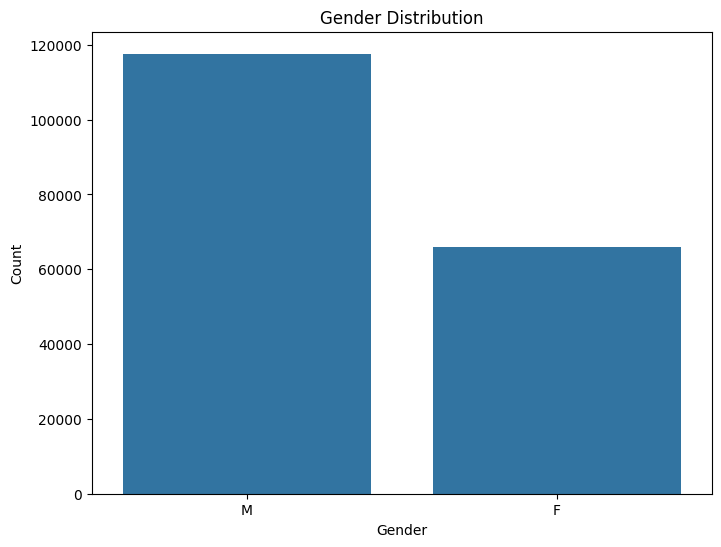

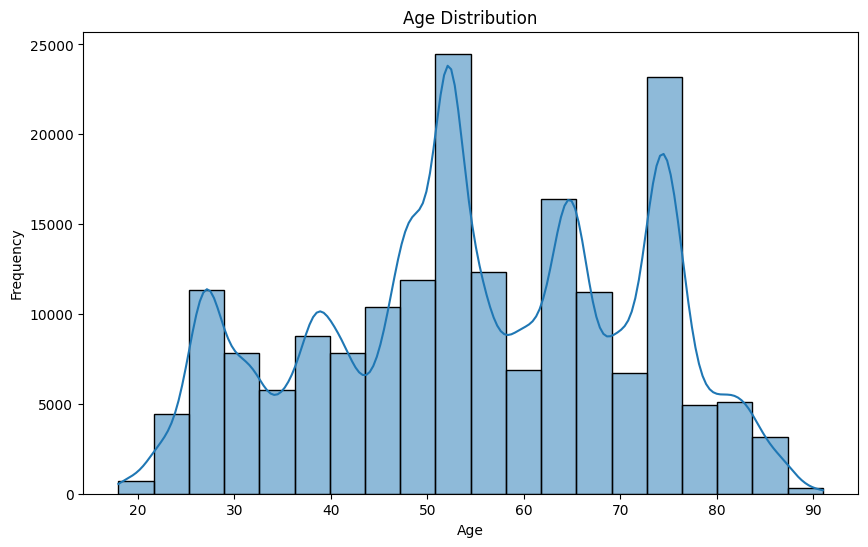

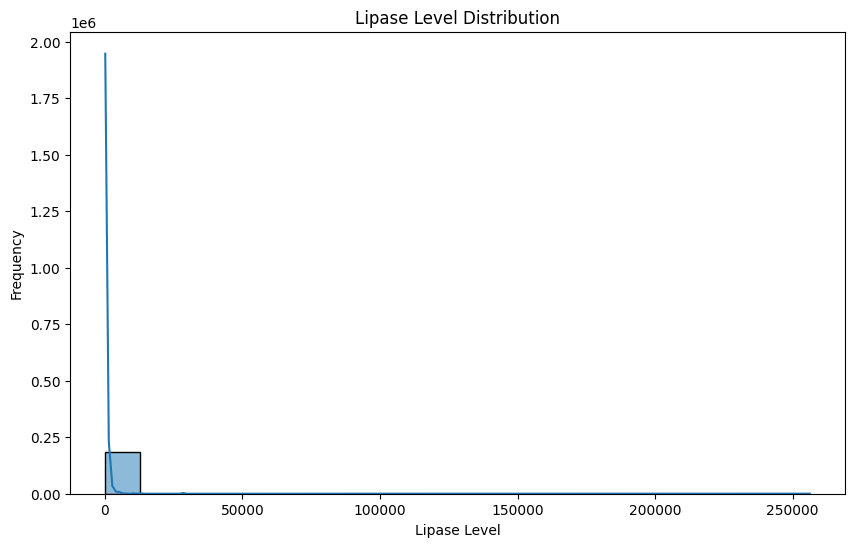

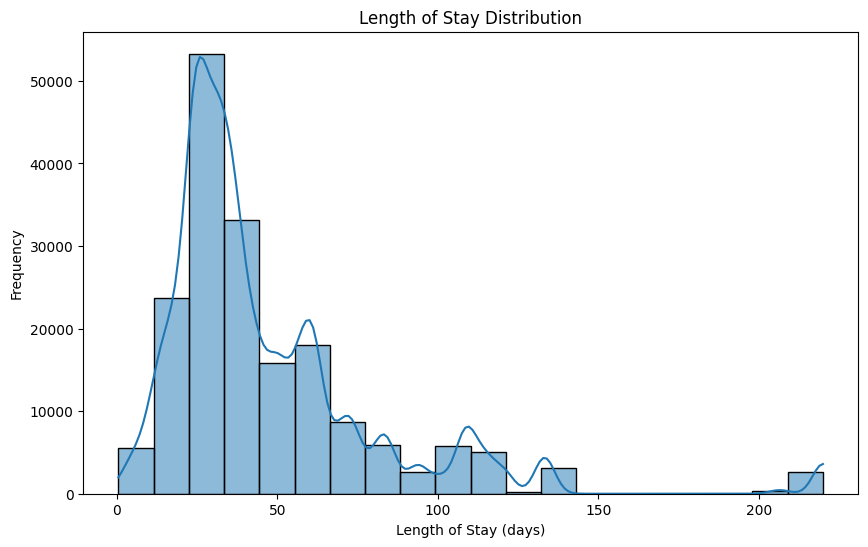

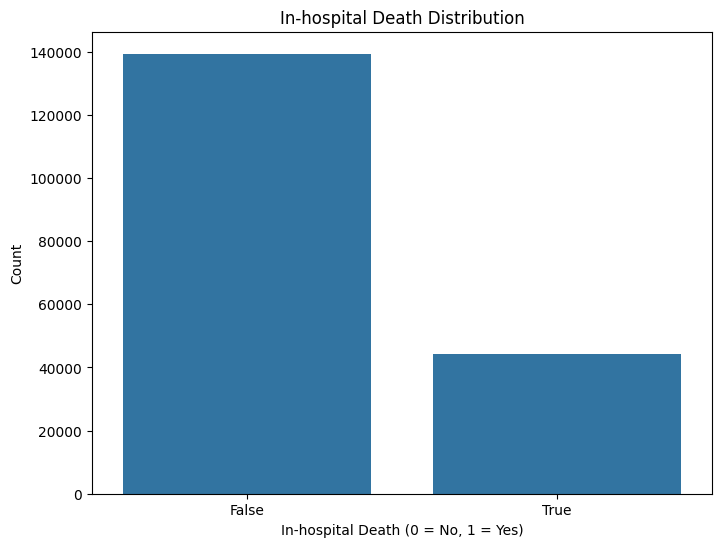

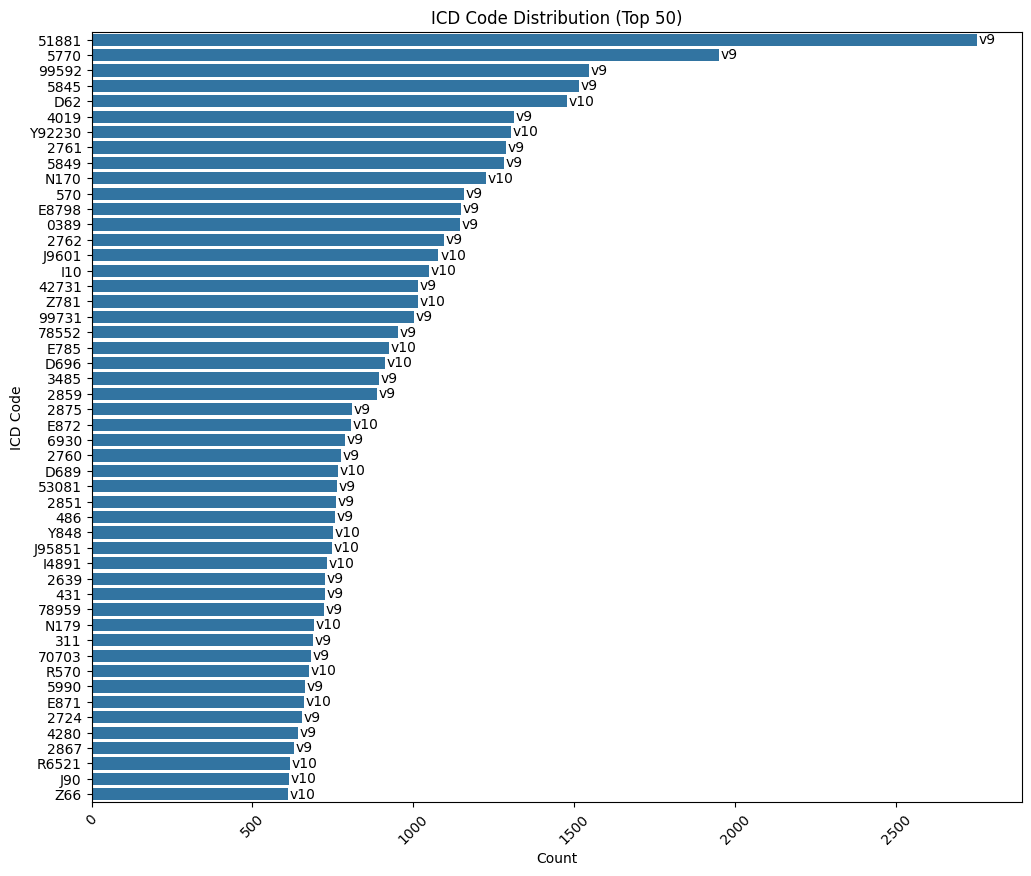

In [162]:
# 3. visualize the distribution of vital data
import matplotlib.pyplot as plt
import seaborn as sns

# Gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=merged_comorbidities_df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Age
plt.figure(figsize=(10, 6))
sns.histplot(merged_comorbidities_df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Lipase levels
plt.figure(figsize=(10, 6))
sns.histplot(merged_comorbidities_df['lipase_level'], bins=20, kde=True)
plt.title('Lipase Level Distribution')
plt.xlabel('Lipase Level')
plt.ylabel('Frequency')
plt.show()

# Length of stay
plt.figure(figsize=(10, 6))
sns.histplot(merged_comorbidities_df['length_of_stay'], bins=20, kde=True)
plt.title('Length of Stay Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()


# In-hospital death
plt.figure(figsize=(8, 6))
sns.countplot(x='in_hospital_death', data=merged_comorbidities_df)
plt.title('In-hospital Death Distribution')
plt.xlabel('In-hospital Death (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# ICD codes
plt.figure(figsize=(12, 10))
ax = sns.countplot(y='icd_code', 
                   data=merged_comorbidities_df, 
                   order=merged_comorbidities_df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')
for index, patch in enumerate(ax.patches):
    icd_code = merged_comorbidities_df['icd_code'].value_counts().index[:50][index]
    icd_version = merged_comorbidities_df.loc[merged_comorbidities_df['icd_code'] == icd_code, 'icd_version'].iloc[0]
    x = patch.get_width() + 5 
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'v{icd_version}', va='center')
plt.xticks(rotation=45)
plt.show()

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


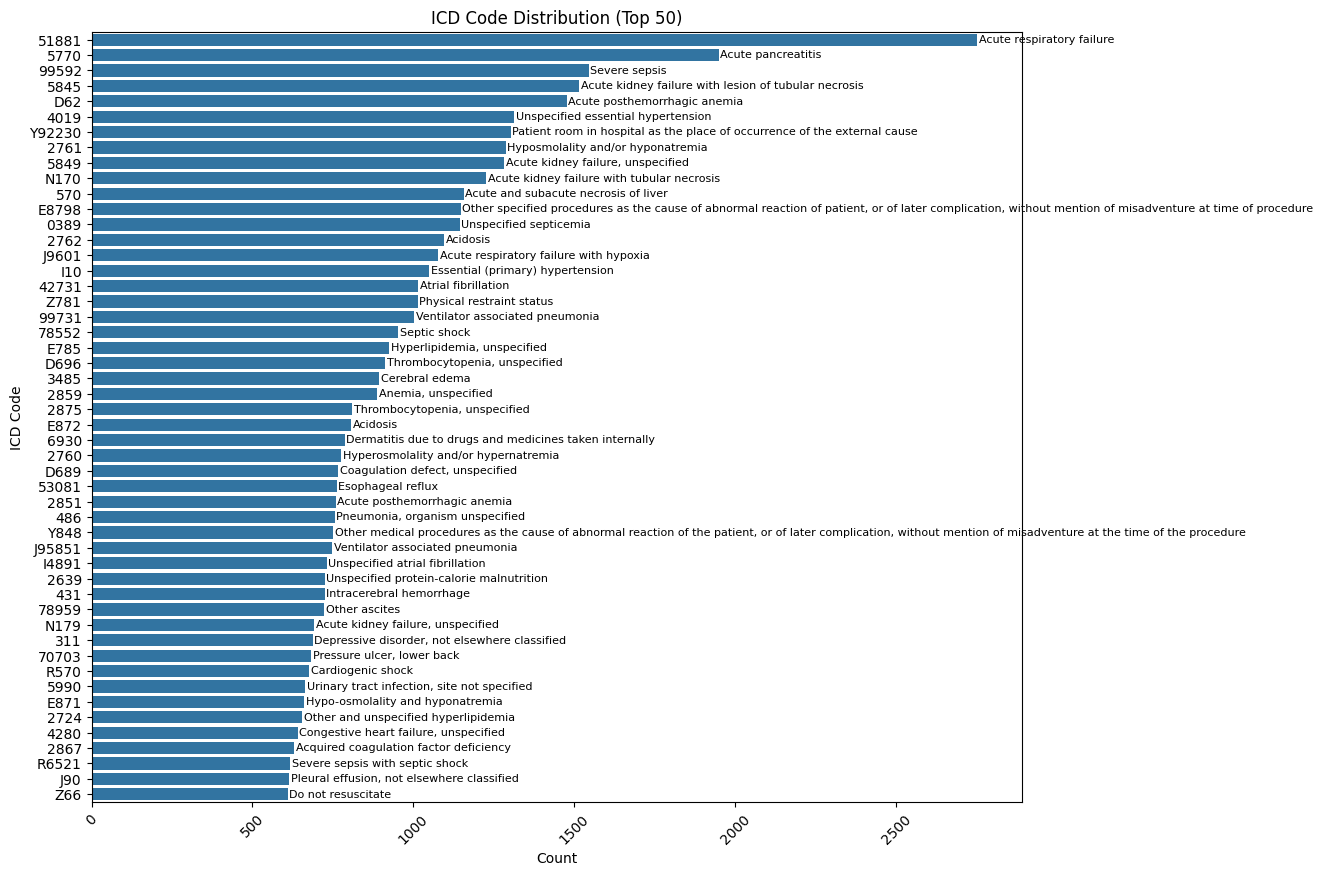

In [163]:
icd_title_query = """
SELECT icd_code, icd_version, long_title
FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`
"""
icd_titles_df = run_query(icd_title_query)

merged_comorbidities_df = pd.merge(merged_comorbidities_df, icd_titles_df, on=['icd_code', 'icd_version'], how='left')

plt.figure(figsize=(12, 10))
ax = sns.countplot(y='icd_code', 
                   data=merged_comorbidities_df, 
                   order=merged_comorbidities_df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')

for index, patch in enumerate(ax.patches):
    icd_code = merged_comorbidities_df['icd_code'].value_counts().index[:50][index]
    long_title = merged_comorbidities_df.loc[merged_comorbidities_df['icd_code'] == icd_code, 'long_title'].iloc[0]
    x = patch.get_width() + 5 
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'{long_title}', va='center', fontsize=8, color='black')

plt.xticks(rotation=45)
plt.show()